In [46]:
import os
from google.colab import drive
drive.mount('/content/drive/')
os.chdir('/content/drive/MyDrive/QuinyxDocuments/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [91]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold, cross_val_score, train_test_split
import seaborn as sns
from sklearn.multioutput import MultiOutputRegressor

In [ ]:
'''
Each row of the data consists of vessel arrivals and departures (eta, ata, atd), 
along with the load and discharge amount of each cargo type (oil, coal, oil, petrolium).
The goal is to predict the load and discharge of each cargo shipment.

To do this, we will perform:
1. Find the description of the data
2. Data cleaning, and pre-processing.
3. Exploratory data analysis and Feature engineering.
4. Building ML model.
5. Model optimization.
6. Evaluation
'''

## Data Loading and Pre-processing

In [ ]:
# Load the data into a pd df
df_vessel = pd.read_excel('VesselData.xlsx')
df_vessel

In [49]:
# Check for NaN
print("Columns with NaN", df_vessel.columns[df_vessel.isna().any()].tolist())

Columns with NaN ['vesseldwt', 'stevedorenames', 'hasnohamis']


In [ ]:
# Check the amount of NaNs for each column
print("Num of NaNs in vesseldwt", df_vessel['vesseldwt'].isnull().values.sum())
print("Num of NaNs in stevedorenames", df_vessel['stevedorenames'].isnull().values.sum())
print("Num of NaNs in hasnohamis", df_vessel['hasnohamis'].isnull().values.sum())

In [ ]:
# We can either drop of fill NaNs
# As hasnohamis consists of all NaNs, we drop the column
df_vessel = df_vessel.drop(columns=['hasnohamis'])
# Here, as we're unsure of the appropriate values to fill the NaN rows of vesseldwt and stevedorenames columns, we drop them
df_vessel = df_vessel.dropna()
df_vessel

In [52]:
# We set vesselid as the index, instead of a feature (column)
df_vessel = df_vessel.set_index('vesselid')

In [53]:
# We make 4 different df's for each product
df_vessel_1 = df_vessel.drop(columns=['discharge2', 'discharge3', 'discharge4', 'load2', 'load3', 'load4'])
df_vessel_2 = df_vessel.drop(columns=['discharge1', 'discharge3', 'discharge4', 'load1', 'load3', 'load4'])
df_vessel_3 = df_vessel.drop(columns=['discharge2', 'discharge1', 'discharge4', 'load2', 'load1', 'load4'])
df_vessel_4 = df_vessel.drop(columns=['discharge2', 'discharge3', 'discharge1', 'load2', 'load3', 'load1'])

## Exploratory Data Analysis and Feature Engineering


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


0.0012461852378713098

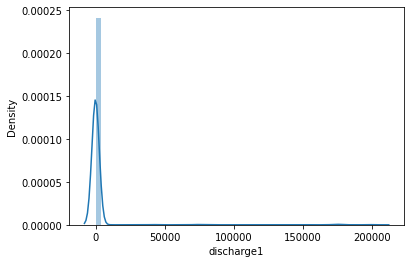

In [61]:
# Check for skewness in each target variable
# discharge 1
sns.distplot(df_vessel_1['discharge1'])
# average skewness
df_vessel_1['discharge1'].skew() / len(df_vessel_1)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


0.001409441160175467

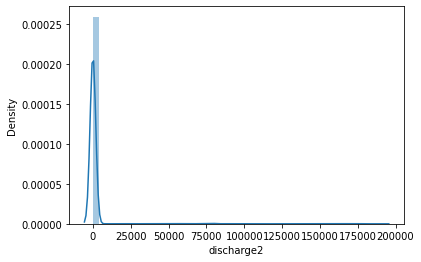

In [62]:
# discharge 2
sns.distplot(df_vessel_2['discharge2'])
# average skewness
df_vessel_2['discharge2'].skew() / len(df_vessel_2)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


0.0008358950511220982

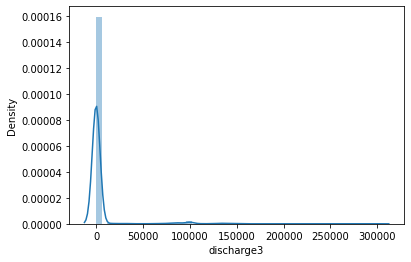

In [64]:
# discharge 3
sns.distplot(df_vessel['discharge3'])
# average skewness
df_vessel_3['discharge3'].skew() / len(df_vessel_3)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


0.000988528584119653

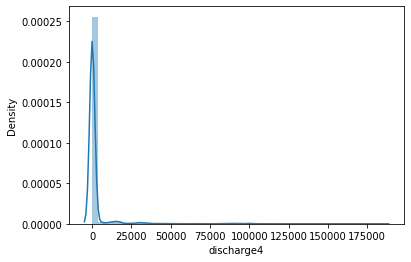

In [66]:
# discharge 4
sns.distplot(df_vessel['discharge4'])
# average skewness
df_vessel_4['discharge4'].skew() / len(df_vessel_4)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


0.0032877714680516028

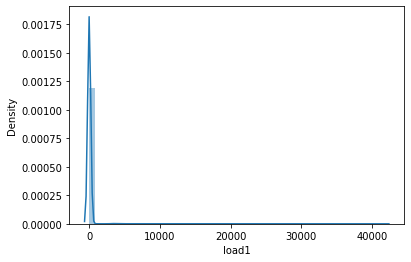

In [67]:
# load 1
sns.distplot(df_vessel['load1'])
# average skewness
df_vessel_1['load1'].skew() / len(df_vessel_1)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


0.006546317566984212

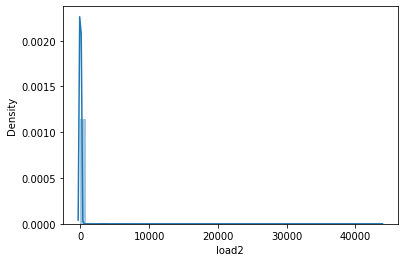

In [68]:
# load 2
sns.distplot(df_vessel['load2'])
# average skewness
df_vessel_2['load2'].skew() / len(df_vessel_2)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


0.010333584403740473

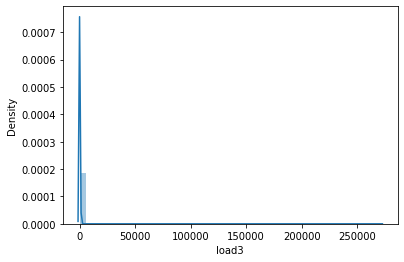

In [69]:
# load 3
sns.distplot(df_vessel['load3'])
# average skewness
df_vessel_3['load3'].skew() / len(df_vessel_3)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


0.0019048114694594517

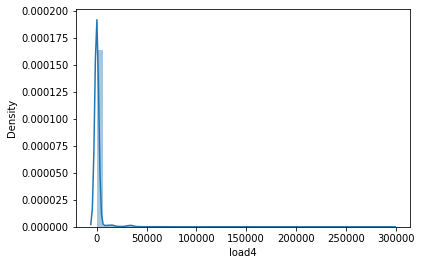

In [72]:
# load 4
sns.distplot(df_vessel['load4'])
# average skewness
df_vessel_4['load4'].skew() / len(df_vessel_4)

We don't observe any major skewness in the data, based on the skewness score. Therefore, we don't need to do any transformation.

### Statistical Analysis
Due to limited available documentation and domain knowledge, we do a blind statistical analysis mostly on numerical features. Additionally, we take object type columns which consist of few of unique values.

In [ ]:
# Example of number of unique values per column for our df
# Complete result for each df will be explained in the Part 3 of the assessment
unique_values = []
df_vessel_1.columns.nunique
for col in df_vessel_1.columns:
  unique_values.append(df_vessel_1[col].nunique())
unique_values  

### We then see which features to drop (by correlation with target variable and by multicollinearity).

In [89]:
# We convert the TravelType column (which has only few unique values) to dummy variable
df_vessel_1['traveltype_no'] = -1
df_vessel_2['traveltype_no'] = -1
df_vessel_3['traveltype_no'] = -1
df_vessel_4['traveltype_no'] = -1

for i in range(len(df_vessel_1)):
  if (df_vessel_1['traveltype'].values[i] == 'ARRIVAL'):
    df_vessel_1['traveltype_no'].values[i] = 0
  else:
    df_vessel_1['traveltype_no'].values[i] = 1

for i in range(len(df_vessel_2)):
  if (df_vessel_2['traveltype'].values[i] == 'ARRIVAL'):
    df_vessel_2['traveltype_no'].values[i] = 0
  else:
    df_vessel_2['traveltype_no'].values[i] = 1

for i in range(len(df_vessel_3)):
  if (df_vessel_3['traveltype'].values[i] == 'ARRIVAL'):
    df_vessel_3['traveltype_no'].values[i] = 0
  else:
    df_vessel_3['traveltype_no'].values[i] = 1

for i in range(len(df_vessel_4)):
  if (df_vessel_4['traveltype'].values[i] == 'ARRIVAL'):
    df_vessel_4['traveltype_no'].values[i] = 0
  else:
    df_vessel_4['traveltype_no'].values[i] = 1

In [ ]:
# Calculate correlation with each target variable
# Cargo 1
corr_matrix = df_vessel_1.corr()
print(corr_matrix['discharge1'].sort_values(ascending=False), "Correlation of the features with discharge1")
print(corr_matrix['load1'].sort_values(ascending=False), "Correlation of the features with load1")

In [ ]:
# Calculate correlation with each target variable
# Cargo 2
print(corr_matrix['discharge2'].sort_values(ascending=False), "Correlation of the features with discharge2")
print(corr_matrix['load2'].sort_values(ascending=False), "Correlation of the features with load2")

In [ ]:
# Calculate correlation with each target variable
# Cargo 3
print(corr_matrix['discharge3'].sort_values(ascending=False), "Correlation of the features with discharge3")
print(corr_matrix['load3'].sort_values(ascending=False), "Correlation of the features with load3")

In [ ]:
# Calculate correlation with each target variable
# Cargo 4
print(corr_matrix['discharge4'].sort_values(ascending=False), "Correlation of the features with discharge4")
print(corr_matrix['load4'].sort_values(ascending=False), "Correlation of the features with load4")

In [ ]:
# Converting categorical variables to numerical
df_vessel = pd.get_dummies(df_vessel)

Multicollinearity test with Variance Inflation Factor. Highly correlateed features tend to give high variances, which is difficult for our model to learn

In [ ]:
# Here as example, we perform VIF on the df_vessel_1 data
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = pd.get_dummies(df_vessel_1).drop(columns=['load1', 'discharged1'])

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
print(vif_data.sort_values(by = 'VIF', ascending = False))

After these steps, we would drop the features which are not correlated with the target variable or are highly correlated with another features. In this assignment, however, we did not have enough time to do this.

## Building ML model

Possible solution for this application is the Sklearn MultiOutputRegressor for each dataframe:

https://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputRegressor.html

as we have 2 target variables (discharge and load).
The steps involved here comprises of:
1. Train/test/val split 
2. Building the model

In [ ]:
# For xample we split as follows
X = df_vessel_1.drop(['load1','discharge1'],axis=1)
y = df_vessel_1['load1','discharge1']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=56)

# Validation set (if needed)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=56)

## Optimization 
Optimization can be done by performing either GridSearch, RandomSearch, or Bayesian Optimization. Additionally, if we would like to test other models, we can do so by performing k-fold cross validation (optionally via PyCaret library)

## Evaluation
This can be done by either measuring MSE or RMSE of the model, or MAE if the data contains lots of outliers.

## Final Revised/Improved Approach

In [ ]:
# Available Data (Input) - 
# 'eta','ata','atd','vesseldwt','vesseltype','stevedorenames','hasnohamis', 'earliesteta'
# 'latesteta','traveltype',# 'previousportid', 'nextportid', 'isremarkable','vesselid'

# Available Data (Output) - Total load (float) and discharge (float) activities (Output)

# Scenario - Vessels with 5 types of cargo (given by 'vesseltype') load and unload cargo at different ports. 
# 'dischargeX' and 'loadX' -> represents the type of cargo discharged and loaded.
# => vesseltype_1 <--> discharge1 and load1
#...
# => vesseltype_4 <--> discharge4 and load4
# => vesseltype_5 <--> Applicable to all discharge and loads


# Client Requirement - Finding load and discharge activities of each type of incoming cargo vessels 


# Solution:
# 1. Data Analysis: Create a detailed description of the features to find related features.
# 2. Preprocessing: Convert traveltype to float
# 3. Feature Engineering: Drop the features with object type and use all features with float type.
# 4. Prediction: Use multioutput regressor (sklearn.multioutput.MultiOutputRegressor) 
#    for predicting the load/unload values for each vessel type